




# Monitoring Water Saturation Variations in Landes Sand
Data from Thomas. 

*Version 2:* Modified Walton model (Pride, 2005) is used instead of Hertz-Mindlin model to estimate drained properties. This is more consistent with the velocity dependence upon pressure observed for the low pressure range (below 10 MPa).

Modelled using *Solazzi, S. G., Bodet, L., Holliger, K., & Jougnot, D. (2021). Surface‐Wave Dispersion in Partially Saturated Soils: The Role of Capillary Forces. Journal of Geophysical Research: Solid Earth, e2021JB022074*.

Notebook sections:
- [Load packages and routines](#load_packages)
- [Plotting parameters](#plot_param)
- [Load data](#load_data)
- [Vp and Vs Modeling using Solazzi et al. (2021) (knowing $S_w$ and $P_f$)](#model_vp_vs_z28)
- [Van Genuchten parameters insight using saturation profiles](#vg_param_sat_profiles)
- [Appendix A : Check Vp, Vs range (Vp should be around 150 m/s at the surface)](#AppA_Vp_Vs_range)

<a id=load_packages></a>
### Load packages and routines

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Go to Python folder to import routines
if os.getcwd() != '/Users/clarisse/Desktop/Recherche/Publis/16_Gaubert_et_al_Labo/Olivia': 
    os.chdir('/Users/clarisse/Desktop/Recherche/Publis/16_Gaubert_et_al_Labo/Olivia')
print('Current directory: ', os.getcwd())
print('Python folders: ', [x for x in os.listdir() if '.' not in x])

Current directory:  /Users/clarisse/Desktop/Recherche/Publis/16_Gaubert_et_al_Labo/Olivia
Python folders:  ['EffectiveMedia', 'Utils', 'Fluid', 'Hydro']


In [3]:
# Import routines
from EffectiveMedia.GranularModels import Walton_modified
from Fluid.Gassmann import isoGassmann, fluidWood
from Hydro.hydro_models import Swe_from_wt_VG
from Utils.bounds import HillAvr
from Utils.elastic_param import Vp_from_K_G, Vs_from_G

<a id=plot_param></a>
### Plotting parameters

In [4]:
# Plot parameters
plt.rc('axes',labelsize=16)
plt.rc('font',size=14)
plt.rc('xtick',labelsize='medium')
plt.rc('ytick',labelsize='medium')
plt.rc('grid', linestyle=':', linewidth=0.5)

<a id=load_data></a>
### Load data

Data file contains :
- water saturation (Sw) measured at different depths (see depth array), evry 10 s over 72 hours; 
- fluid pressure (Pw) measured at the bottom of the tank (approx. 55 cm depth - to be checked wit Thomas);
- fluid pressure (Pf) measured at 28 cm depth;
- depth array (depth) indicating depth of water saturation measurements.

In [5]:
os.chdir('/Users/clarisse/Desktop/Recherche/Publis/16_Gaubert_et_al_Labo/Olivia')
os.listdir()

['Pressurevel.jpg',
 'Solazzi_et_al_Model_Fig4.ipynb',
 '.DS_Store',
 'Utils.zip',
 'Fluid.zip',
 'Resume_DonneesThomas(1).pptx',
 'dv_median.npy',
 'Saturation_Pw_Pf_depth_Clarisse.npy',
 'NPwPf.npy',
 'EffectiveMedia',
 'Utils',
 'Final_PwPf.npy',
 'Fluid',
 'Solazzi_et_al_Model_Fig3.ipynb',
 'HydroData_Thomas_v2-Copy1.ipynb',
 'Hydro.zip',
 'HertzMindlin_vs_Walton_models.ipynb',
 'HydroData_Thomas_v2.ipynb',
 'PressuresVel.pdf',
 '.ipynb_checkpoints',
 'EffectiveMedia.zip',
 'HydroData_Thomas_v1.ipynb',
 'Solazzi_et_al_Model_Landes_sand.ipynb',
 'Solazzi_et_al_Model_SensitivitySw2VanGenuchtenParam.ipynb',
 'Hydro',
 'Saturation_Pw_Pf_depth_Clarisse2.npy']

In [6]:
Sw, Pw, Pf, depth = np.load(r'Saturation_Pw_Pf_depth_Clarisse.npy',
                            allow_pickle=True)

In [7]:
np.shape(Sw)

(12, 25920)

In [8]:
np.shape(Pf)

(25920,)

Convert pressures from mbar to kPa.

In [9]:
Pw = Pw*1e-1 # kPa
Pf = Pf*1e-1 # kPa

Time vector corresponding to data (one point every 10 s for 72 hours = 4320 min = 259200 s).

In [10]:
t = np.arange(0,259200,10)

#### Saturation Data at 27 cm Depth

In [11]:
depth

array([ -9, -12, -15, -18, -21, -24, -27, -30, -33, -39, -42, -48],
      dtype=int32)

In [12]:
i_piezo = np.where(depth==-27)[0][0]
i_piezo

6

In [13]:
Sw27 = Sw[i_piezo,:]

In [14]:
np.shape(Sw27)

(25920,)

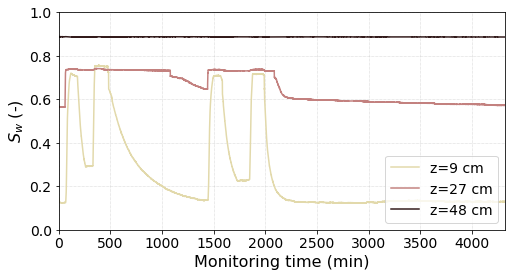

In [15]:
fig = plt.figure(figsize=(8,4))
ax = plt.axes()

color_map = 'pink_r'
cmap = plt.get_cmap(color_map, 60)
shift_cmap = 10 #to avoid light colors

ax.plot(t/60, Sw[0,:], color=cmap(-depth[0]+shift_cmap), label='z='+str(-depth[0])+' cm')
ax.plot(t/60, Sw27, color=cmap(-depth[i_piezo]+shift_cmap), label='z='+str(-depth[i_piezo])+' cm')
ax.plot(t/60, Sw[-1,:], color=cmap(-depth[-1]+shift_cmap), label='z='+str(-depth[-1])+' cm')
ax.set(xlabel='Monitoring time (min)', xlim=[0,4320],
       ylabel='$S_w$ (-)',ylim=[0,1])
ax.legend(loc='lower right')
ax.grid()
plt.show()

#### Pressure Data

Plot fluid pressure measured at the bottom of the tank ($P_w$) and at 28 cm depth ($P_f$). 

In [16]:
# Check hydrostatic values for depth=28cm and depth=54cm
rho_w = 1.0*1e3            # water density (kg/m3)
g = 9.806                  # Earth’s gravitational acceleration (m.s^-2)
z = np.array([28,54])*1e-2 # depth (m)
Phydro = rho_w*g*z*1e-3    # computed hydrostatic pressure (kPa)
Phydro

array([2.74568, 5.29524])

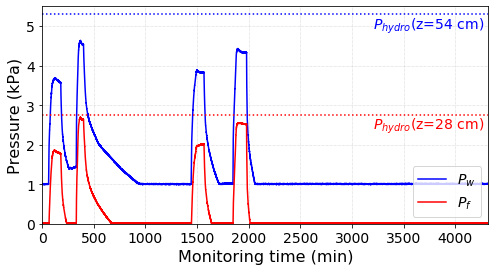

In [17]:
fig = plt.figure(figsize=(8,4))
ax = plt.axes()

ax.plot(t/60, Pw, label='$P_w$', color='blue')
ax.plot(t/60, Pf, label='$P_f$', color='red')
ax.plot([0,t[-1]/60],[Phydro[0],Phydro[0]], 'r:')
ax.plot([0,t[-1]/60],[Phydro[1],Phydro[1]], 'b:')
ax.text(3200, Phydro[0]-0.35, '$P_{hydro}$(z='+str(int(z[0]*1e2))+' cm)', color='r')
ax.text(3200, Phydro[1]-0.35, '$P_{hydro}$(z='+str(int(z[1]*1e2))+' cm)', color='b')
ax.set(xlabel='Monitoring time (min)', xlim=[0,4320],
       ylabel='Pressure (kPa)', ylim=[0,5.5])
ax.legend(loc='lower right')
ax.grid()
plt.show()

Compare pressure data with hydrostatic pressure computed assuming effective fluid : 

In [18]:
# #Set maximum saturation to 0.8 (no change in voltage between 0.8 and 1.0 when measuring sat)
# Sw[Sw>0.8]=0.8
# np.max(Sw)

# # #Remove 0.05 or 0.1 to water sat
# Sw -= 0.05
# np.min(Sw)

In [19]:
prod_SwDepth_min = np.zeros(np.shape(Sw))
for i_depth in range(1,len(depth)):
    prod_SwDepth_min[i_depth,:] = Sw[i_depth-1,:]*abs(depth[i_depth]-depth[i_depth-1])*1e-2

In [20]:
prod_SwDepth_max = np.zeros(np.shape(Sw))
prod_SwDepth_max[0,:] = Sw[0,:]*abs(depth[0])*1e-2
for i_depth in range(1,len(depth)):
    prod_SwDepth_max[i_depth,:] = Sw[i_depth,:]*abs(depth[i_depth]-depth[i_depth-1])*1e-2

In [21]:
Pp_piezo_min = np.sum(prod_SwDepth_min[0:i_piezo+1,:], axis=0)*rho_w*g*1e-3 # computed pressure assuming effective fluid (kPa)
Pp_bottom_min = np.sum(prod_SwDepth_min, axis=0)*rho_w*g*1e-3 # computed pressure assuming effective fluid (kPa)

Pp_piezo_max = np.sum(prod_SwDepth_max[0:i_piezo+1,:], axis=0)*rho_w*g*1e-3 # computed pressure assuming effective fluid (kPa)
Pp_bottom_max = np.sum(prod_SwDepth_max, axis=0)*rho_w*g*1e-3 # computed pressure assuming effective fluid (kPa)

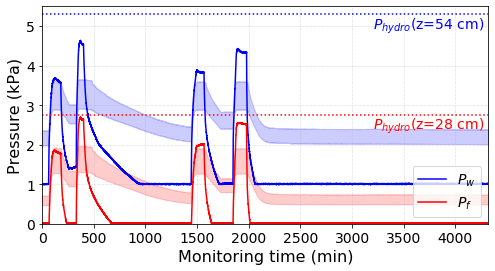

In [22]:
fig = plt.figure(figsize=(8,4))
ax = plt.axes()

ax.plot(t/60, Pw, label='$P_w$', color='blue')
ax.plot(t/60, Pf, label='$P_f$', color='red')
ax.fill_between(t/60, Pp_bottom_min, Pp_bottom_max, color='b', alpha=0.2)
ax.fill_between(t/60, Pp_piezo_min, Pp_piezo_max, color='r', alpha=0.2)
ax.plot([0,t[-1]/60],[Phydro[0],Phydro[0]], 'r:')
ax.plot([0,t[-1]/60],[Phydro[1],Phydro[1]], 'b:')
ax.text(3200, Phydro[0]-0.35, '$P_{hydro}$(z='+str(int(z[0]*1e2))+' cm)', color='r')
ax.text(3200, Phydro[1]-0.35, '$P_{hydro}$(z='+str(int(z[1]*1e2))+' cm)', color='b')
ax.set(xlabel='Monitoring time (min)', xlim=[0,4320],
       ylabel='Pressure (kPa)', ylim=[0,5.5])
ax.legend(loc='lower right')
ax.grid()
plt.show()

<a id=model_vp_vs_z28></a>
### Vp and Vs Modeling using Solazzi et al. (2021) (knowing $S_w$ and $P_f$)

In [23]:
# Mineral properties
K_Qz = 44      #GPa (Barriere et al., GJI 2012)
G_Qz = 36      #GPa (Barriere et al., GJI 2012)
rho_Qz = 2.65  #g/cc (Barriere et al., GJI 2012)
K_Ka = 1.5     #GPa
G_Ka = 1.4     #GPa
rho_Ka = 1.58  #g/cc
f_Qz = 1.0     #unitless

# Fluid properties
Kw = 2.3     #GPa
rho_w = 1.0  #g/cc
Ka = 1e-4    #GPa
rho_a = 1e-3 #g/cc

# Rock matrix properties
phi = 0.40  #Porosity - measured (Barriere et al., GJI 2012)
C0 = 9      #Coordination number in the high stress limit - Landes Sand (Barriere et al., GJI 2012)
R = 3/5     #Walton friction parameter (Barriere et al., GJI 2012)
P0 = 18     #Critical pressure for modified Walton model (MPa) - (Barriere et al., GJI 2012)
Swr = 0.15  #Residual water saturation (to confirm with Thomas)

#### Grain properties

In [24]:
Ks = HillAvr(K_Qz, f_Qz, K_Ka)        #GPa
Gs = HillAvr(G_Qz, f_Qz, G_Ka)        #GPa
rho_s = rho_Qz*f_Qz + (1-f_Qz)*rho_Ka #g/cc

#### Fluid properties

In [25]:
rho_f = Sw27*rho_w + (1-Sw27)*rho_a  #g/cc (fluid density at piezometer level)
rho_f_full = Sw*rho_w + (1-Sw)*rho_a #g/cc
Kf = fluidWood(Sw27, Kw, Ka)         #GPa

#### Density changes

In [26]:
# Bulk density
rho_sat = rho_s*(1-phi) + rho_f*phi        #g/cc (fluid density at piezometer level)
rho_sat_full = rho_s*(1-phi) + rho_f_full*phi #g/cc 

#### Modeling of P- and S-wave velocities

Here, we assume that the effective pressure is given by : 
\begin{equation}
P_e(S_w) = \sigma(S_w) - \chi(S_w)P_p
\end{equation}

where : 
- $S_w$ is the water saturation,
- $P_e$ is the effective pressure, 
- $\sigma$ is the overburden stress,
- $P_p$ is the measured pore presure.

In [27]:
# Overburden stress
z = 27*1e-2         # depth (m)
# New version - 28/10/2022
prod_rhoDepth_min = np.zeros(np.shape(Sw))
for i_depth in range(1,len(depth)):
    prod_rhoDepth_min[i_depth,:] = rho_sat_full[i_depth-1,:]*1e3*abs(depth[i_depth]-depth[i_depth-1])*1e-2
P = np.sum(prod_rhoDepth_min[0:i_piezo+1,:], axis=0)*g
# # Old version - 28/10/2022
# P = rho_sat*1e3*g*z # overburden stress (Pa)
# # END
P *= 1e-6           # conversion Pa -> MPa

# Effective pressure
#-- Test Peff = P - Pf
Peff = P - Pf*1e-3  # effective pressure (MPa)
# #-- Test Peff = P - Swe*Pf
# Swe = (Sw27-Swr)/(1-Swr)
# Peff = P - Swe*Pf*1e-3  # effective pressure (MPa)
# #-- Test Peff = P
# Peff = P # effective pressure (MPa)

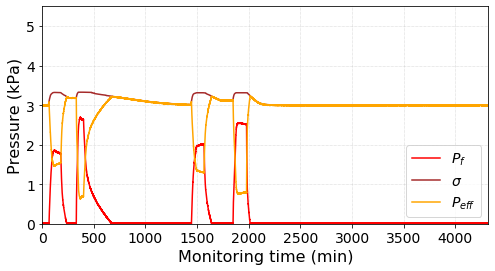

In [28]:
fig = plt.figure(figsize=(8,4))
ax = plt.axes()

ax.plot(t/60, Pf, label='$P_f$', color='red')
ax.plot(t/60, P*1e3, label='$\sigma$', color='brown')
ax.plot(t/60, Peff*1e3, label='$P_{eff}$', color='orange')
ax.set(xlabel='Monitoring time (min)', xlim=[0,4320],
       ylabel='Pressure (kPa)', ylim=[0,5.5])
ax.legend(loc='lower right')
ax.grid()
plt.show()

In [29]:
# Drained properties
Kdr, Gdr = Walton_modified(Ks, Gs, Peff, P0, phi=phi, C0=C0, R=R) 

# Saturated properties
Ksat = isoGassmann(Kdr, Gdr, Ks, Kf, phi)
Vp_sat = Vp_from_K_G(Ksat, Gdr, rho_sat)
Vs_sat = Vs_from_G(Gdr, rho_sat)

# Reference velocities (same as Thomas, avg of velocities between 2300 and 3000 min)
t_ref1 = int(2300*60/10)
t_ref2 = int(3000*60/10)
Vp_ref = np.mean(Vp_sat[t_ref1:t_ref2]); print('Vp_ref = {:.1f} m/s'.format(Vp_ref*1e3))
Vs_ref = np.mean(Vs_sat[t_ref1:t_ref2]); print('Vs_ref = {:.1f} m/s'.format(Vs_ref*1e3))

Vp_ref = 159.0 m/s
Vs_ref = 91.2 m/s


In [30]:
print(np.min(Kdr),np.max(Kdr))

0.01160303856472132 0.026321199452342334


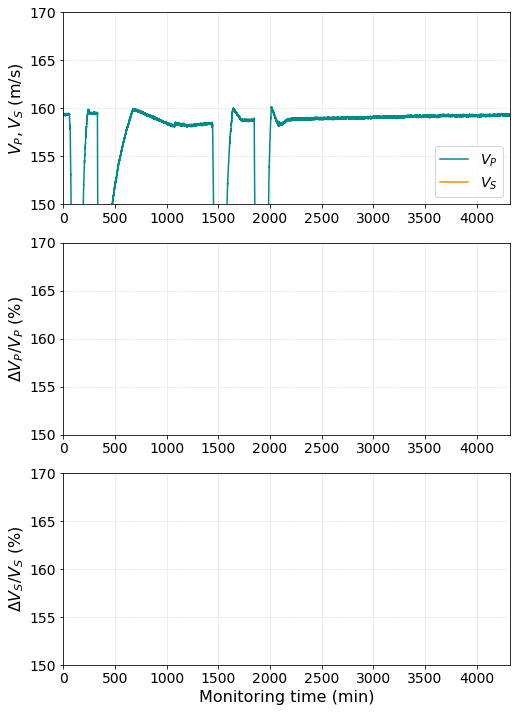

In [31]:
#Plot
fig, axs = plt.subplots(3,1, figsize=(8,12))
axs[0].plot(t/60, Vp_sat*1e3, color='darkcyan', label='$V_P$')
axs[0].plot(t/60, Vs_sat*1e3, color='darkorange', label='$V_S$')
axs[1].plot(t/60, (Vp_sat-Vp_ref)/Vp_ref*1e2, color='darkcyan')
axs[2].plot(t/60, (Vs_sat-Vs_ref)/Vs_ref*1e2, color='darkorange')
#Plot param
axs[0].set(ylabel='$V_P, V_S$ (m/s)', ylim=[0,300])
axs[0].legend(loc='lower right')
axs[1].set(ylabel='$\Delta V_P/V_P$ (%)')
axs[2].set(ylabel='$\Delta V_S/V_S$ (%)',
           xlabel='Monitoring time (min)')
for i in range(0,3):
    axs[i].set(xlim=[0,4320])
    axs[i].set(ylim=[150,170])
    
    axs[i].grid()
plt.show()

<a id=vg_param_sat_profiles></a>
### Van Genuchten Parameters Insight Using Saturation Profiles

In [32]:
# Import hydraulic data (Table 1 - Thomas's paper)
hydro_cycle_data = pd.read_csv('Hydro_cycle_data.txt', sep=' ', index_col='Type')
hydro_cycle_data

FileNotFoundError: [Errno 2] File b'Hydro_cycle_data.txt' does not exist: b'Hydro_cycle_data.txt'

In [33]:
# Parameters for Van Genuchten model
z = np.linspace(0,-50,101)
alpha_vg = 10.
n_vg = 1.82
test_alpha = True
alpha_vg_test = np.logspace(-1,1,3)

In [34]:
alpha_vg_test

array([ 0.1,  1. , 10. ])

NameError: name 'hydro_cycle_data' is not defined

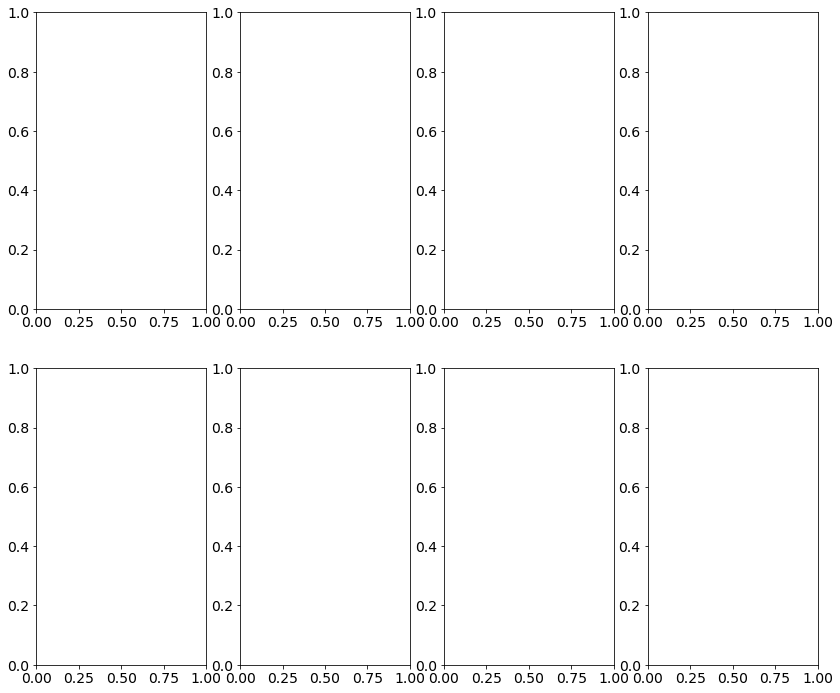

In [35]:
dt = 10 #s

fig, ax = plt.subplots(2,4, figsize=(14,12))

for i_cycle in range(0,8):
    # Get min and max start times
    start_time_min = hydro_cycle_data.loc['Static_'+str(i_cycle),'Start_time']
    end_time_min = hydro_cycle_data.loc['Static_'+str(i_cycle),'End_time']
    # Find corresponding index
    i_start_time = int(start_time_min*60/dt)
    i_end_time = int(end_time_min*60/dt)-1
    # Get water table depth
    wt_ini = hydro_cycle_data.loc['Static_'+str(i_cycle),'Initial_water_table_(cm)']
    wt_fin = hydro_cycle_data.loc['Static_'+str(i_cycle),'Final_Water_table_(cm)']
    wt_avg = 0.5*(wt_ini+wt_fin)
    
    # Set plotting indices
    i_plot = i_cycle%2
    j_plot = i_cycle//2
    # Plot saturation profiles for all times in the selected interval
    for i_time in range(i_start_time,i_end_time):
        ax[i_plot,j_plot].plot(Sw[:,i_time], depth, 'grey', linewidth=0.5)
    # Plot avg saturation on the interval    
    ax[i_plot,j_plot].plot(np.mean(Sw[:,i_start_time:i_end_time],axis=1), depth, 'r')

    # Display avg water table depth on the interval
    ax[i_plot,j_plot].plot([0.,1.],[wt_avg,wt_avg],'k--')

    # Compute and plot predicted saturation using Van Genuchten model
    if test_alpha:
        for alpha_vg in alpha_vg_test : 
            Swe_pred = Swe_from_wt_VG(z, wt_avg, alpha_vg, n_vg)
            Sw_pred = Swe_pred*(1-Swr)+Swr
            # Plot predicted saturation using Van Genuchten model
            ax[i_plot,j_plot].plot(Sw_pred, z, 'b--', linewidth=0.5)            
    else:
        Swe_pred = Swe_from_wt_VG(z, wt_avg, alpha_vg, n_vg)
        Sw_pred = Swe_pred*(1-Swr)+Swr 
        # Plot predicted saturation using Van Genuchten model
        ax[i_plot,j_plot].plot(Sw_pred, z, 'b--', linewidth=0.5)

    # Plot parameters
    ax[i_plot,j_plot].set(xlabel='Sw (-)', xlim=[0,1],
                          ylim=[-50,0])
    if (j_plot==0):
        ax[i_plot,j_plot].set(ylabel='Depth (cm)')
    if (i_plot==0):
        ax[i_plot,j_plot].set(title='Before Imbibition {} \n t=[{},{}] min'.format(j_plot+1,start_time_min,end_time_min))
    else:
        ax[i_plot,j_plot].set(title='After Imbibition {} \n t=[{},{}] min'.format(j_plot+1,start_time_min,end_time_min))    
    ax[i_plot,j_plot].grid()
plt.tight_layout()    
plt.show()

<a id=AppA_Vp_Vs_range></a>
### Appendix A : Check Vp, Vs range (Vp should be around 150 m/s at the surface)

In [36]:
# Input Param
Sw_test = np.linspace(0,1,100)
z = 1*1e-2 # Depth (m) - 1cm to model surface
# -- END Input Param

# Solid properties
Ks = HillAvr(K_Qz, f_Qz, K_Ka)        #GPa
Gs = HillAvr(G_Qz, f_Qz, G_Ka)        #GPa
rho_s = rho_Qz*f_Qz + (1-f_Qz)*rho_Ka #g/cc

# Fluid properties
rho_f = Sw_test*rho_w + (1-Sw_test)*rho_a   #g/cc
Kf = fluidWood(Sw_test, Kw, Ka)        #GPa

# Bulk density
rho_sat = rho_s*(1-phi) + rho_f*phi #g/cc

# Overburden stress
P = rho_sat*1e3*g*z # overburden stress (Pa)
P *= 1e-6           # conversion Pa -> MPa

# Effective pressure
#Peff = P - Pf*1e-3  # effective pressure (MPa)
Swe_test = (Sw_test-Swr)/(1-Swr)
Peff = P  # effective pressure (MPa)

# Drained properties
Kdr, Gdr = Walton_modified(Ks, Gs, Peff, P0, phi=phi, C0=C0, R=R) 

# Saturated properties
Ksat = isoGassmann(Kdr, Gdr, Ks, Kf, phi)
Vp_sat = Vp_from_K_G(Ksat, Gdr, rho_sat)
Vs_sat = Vs_from_G(Gdr, rho_sat)

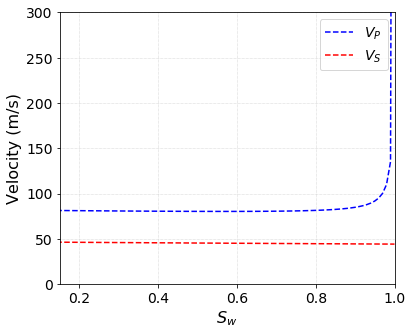

In [37]:
fig, ax = plt.subplots(1,1, figsize=(6,5))
ax.plot(Sw_test, Vp_sat*1e3, 'b--', label='$V_P$')
ax.plot(Sw_test, Vs_sat*1e3, 'r--', label='$V_S$')
#Plot param
ax.set(ylabel='Velocity (m/s)', ylim=[0,300],
       xlabel='$S_w$', xlim=[Swr,1.])
ax.grid()
ax.legend()
plt.show()
plt.show()

> **Note :** Predicted velocities are too low? P-wave velocities should be at around 150 m/s at the surface?

<a id=AppB_Fluid_mixing_laws></a>
### Appendix B : Comparison of fluid mixing laws